In [1]:
!pip install amply pyomo -q

In [14]:

from amplpy import modules
import pyomo.environ as pyo
import pandas as pd
import numpy as np
from pyomo.environ import *


import matplotlib.pyplot as plt
import networkx as nx
import requests



# Caso 1

In [4]:
clientes_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROYECTO_ENTREGA_2\Proyecto Seneca Libre\case_1_base\Clients.csv")
clientes_data.rename(columns = {"ClientID": "ID"}, inplace = True)
print(clientes_data.shape)
clientes_data.sample(5)


(50, 4)


,ID,Product,Longitude,Latitude
3,4,20,-74.069681,4.561071
31,32,10,-74.029082,4.766433
4,5,10,-74.108256,4.703706
5,6,20,-74.030541,4.697555
17,18,18,-74.122705,4.636424


In [5]:
depositos_data = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROYECTO_ENTREGA_2\Proyecto Seneca Libre\case_1_base\Depots.csv")
depositos_data.rename(columns = {"DepotID": "ID"}, inplace = True)
print(depositos_data.shape)
depositos_data.sample(5)

(12, 3)


,ID,Longitude,Latitude
0,1,-74.081242,4.750212
3,4,-74.067069,4.721678
4,5,-74.138263,4.607707
2,3,-74.038548,4.792926
1,2,-74.109934,4.536383


In [7]:
ubicaciones_data = pd.concat([depositos_data[["ID","Longitude", "Latitude"]], clientes_data[["ID","Longitude", "Latitude"]]], axis = 0)
print(ubicaciones_data.shape)
ubicaciones_data.sample(5)

(62, 3)


,ID,Longitude,Latitude
22,23,-74.152345,4.618245
15,16,-74.153452,4.567566
8,9,-74.095472,4.735973
8,9,-74.170485,4.639454
1,2,-74.143629,4.566308


In [8]:
vehiculos = pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROYECTO_ENTREGA_2\Proyecto Seneca Libre\case_1_base\multi_vehicles.csv")
print(vehiculos.shape)
vehiculos.sample(5)

(24, 3)


,VehicleType,Capacity,Range
17,Gas Car,120,116
1,Gas Car,135,195
7,Gas Car,78,133
9,Gas Car,98,107
19,Gas Car,120,167


In [11]:
vehiculos_data= pd.read_csv(r"C:\Users\ACER\OneDrive - Universidad de los Andes\Escritorio\MOS\PROYECTO_ENTREGA_2\Proyecto Seneca Libre\vehicles_data.csv")
print(vehiculos_data.shape)
vehiculos_data.sample(3)

(3, 9)


,Vehicle,Freight Rate [COP/km],Time Rate [COP/min],Daily Maintenance [COP/day],Recharge/Fuel Cost [COP/(gal or kWh)],Recharge/Fuel Time [min/10 percent charge],Avg. Speed [km/h],Gas Efficiency [km/gal],Electricity Efficency [kWh/km]
0,Gas Car,5000,500,30000,16000.00,0.1,NaN,10.0,NaN
2,Solar EV,4000,500,21000,NaN,NaN,NaN,NaN,0.15
1,Drone,500,500,3000,220.73,2.0,40.0,NaN,0.15


In [15]:
num_clientes = 10
clientes_id = RangeSet(1, num_clientes)

In [16]:
num_vehiculos = 5
vehiculos = RangeSet(1, num_vehiculos)

In [17]:
num_tipo_v = 2
tipos_vehiculo = RangeSet(1, num_tipo_v)

In [18]:
num_depositos = 3
deposito_origen = RangeSet(1, num_depositos)  # Definir ciudad de origen


In [ ]:
num_ubicaciones = num_clientes + num_depositos
ubicaciones = RangeSet(1, num_ubicaciones)


In [21]:
def distancia(coor1, coor2):
    service = "route"
    version = "v1"
    profile = "driving"
    coordinates = f"{coor1[0]},{coor1[1]};{coor2[0]},{coor2[1]}"
    overview = "false"

    url = f"http://router.project-osrm.org/{service}/{version}/{profile}/{coordinates}?alternatives=false&overview={overview}"

    try:
        response = requests.get(url)
    except:
        return np.random.randint(1, 5)
    
    if response.status_code == 200:
        return float(response.json()["routes"][0]["distance"])/1000
    else:
        return 99999

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def calcular_costos_distancia(num_ubicaciones, ubicaciones_data, ubicaciones):
    costos_distancia = np.zeros((num_ubicaciones, num_ubicaciones))
    coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
             ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

    # Función para calcular la distancia para un par específico
    def calcular_par_distancia(indices):
        i, j = indices
        return i, j, distancia(coor[i], coor[j])

    # Generar todas las combinaciones de índices
    indices = [(i, j) for i in range(num_ubicaciones) for j in range(num_ubicaciones)]

    # Usar ThreadPoolExecutor para calcular distancias en paralelo
    with ThreadPoolExecutor() as executor:
        resultados = list(executor.map(calcular_par_distancia, indices))

    # Rellenar la matriz con los resultados
    for i, j, dist in resultados:
        costos_distancia[i, j] = dist

    return costos_distancia

In [ ]:
costos_distancia = calcular_costos_distancia(num_ubicaciones, ubicaciones_data, ubicaciones)
costos_distancia

array([[0.00000e+00, 3.30616e+01, 1.01619e+01, 6.45240e+00, 9.99990e+04,
        1.69241e+01, 2.01269e+01, 9.99990e+04, 4.32990e+00, 3.12899e+01,
        1.36590e+01, 2.62234e+01, 1.47593e+01],
       [9.99990e+04, 9.99990e+04, 9.99990e+04, 9.99990e+04, 9.99990e+04,
        1.85269e+01, 9.99990e+04, 9.99990e+04, 9.99990e+04, 2.57140e+00,
        1.92344e+01, 7.37840e+00, 2.75451e+01],
       [1.43307e+01, 3.89127e+01, 0.00000e+00, 1.53473e+01, 3.25636e+01,
        2.89192e+01, 2.66643e+01, 2.35249e+01, 1.85174e+01, 3.71410e+01,
        2.49357e+01, 3.20745e+01, 2.83046e+01],
       [5.15570e+00, 2.68578e+01, 1.05704e+01, 0.00000e+00, 1.72083e+01,
        1.35640e+01, 1.46094e+01, 8.91960e+00, 5.37750e+00, 2.50860e+01,
        1.03304e+01, 2.00196e+01, 1.36993e+01],
       [2.26303e+01, 1.18217e+01, 2.77747e+01, 1.91771e+01, 0.00000e+00,
        5.98240e+00, 7.69110e+00, 1.27530e+01, 2.14381e+01, 1.03723e+01,
        1.04786e+01, 5.40150e+00, 1.73550e+01],
       [1.45738e+01, 1.88891e+

In [24]:
def duracion(coor1, coor2):
    service = "route"
    version = "v1"
    profile = "driving"
    coordinates = f"{coor1[0]},{coor1[1]};{coor2[0]},{coor2[1]}"
    overview = "false"

    url = f"http://router.project-osrm.org/{service}/{version}/{profile}/{coordinates}?alternatives=false&overview={overview}"

    try:
        response = requests.get(url)
    except:
        return np.random.randint(1, 5)
    
    if response.status_code == 200:
        return float(response.json()["routes"][0]["duration"])/60
    else:
        return 99999

In [ ]:
from concurrent.futures import ThreadPoolExecutor
def calcular_costos_duracion(num_ubicaciones, ubicaciones_data, ubicaciones):
    costos_duracion = np.zeros((num_ubicaciones, num_ubicaciones))
    coor = [(ubicaciones_data["Longitude"].to_numpy()[i - 1], 
             ubicaciones_data["Latitude"].to_numpy()[i - 1]) for i in ubicaciones]

    # Función para calcular la duracion para un par específico
    def calcular_par_duracion(indices):
        i, j = indices
        return i, j, duracion(coor[i], coor[j])

    # Generar todas las combinaciones de índices
    indices = [(i, j) for i in range(num_ubicaciones) for j in range(num_ubicaciones)]

    # Usar ThreadPoolExecutor para calcular duraciones en paralelo
    with ThreadPoolExecutor() as executor:
        resultados = list(executor.map(calcular_par_duracion, indices))

    # Rellenar la matriz con los resultados
    for i, j, dura in resultados:
        costos_duracion[i, j] = dura

    return costos_duracion

In [ ]:
costos_duracion = calcular_costos_duracion(num_ubicaciones, ubicaciones_data, ubicaciones)
costos_duracion

array([[0.00000000e+00, 4.18033333e+01, 1.75983333e+01, 1.15316667e+01,
        9.99990000e+04, 2.25866667e+01, 2.40050000e+01, 9.99990000e+04,
        9.99990000e+04, 3.90400000e+01, 1.89850000e+01, 3.33133333e+01,
        2.04233333e+01],
       [4.17083333e+01, 9.99990000e+04, 9.99990000e+04, 3.55966667e+01,
        2.17483333e+01, 2.51383333e+01, 2.09400000e+01, 3.09233333e+01,
        3.82833333e+01, 4.50500000e+00, 2.73833333e+01, 1.42183333e+01,
        4.06666667e+01],
       [1.98366667e+01, 5.29866667e+01, 0.00000000e+00, 2.21616667e+01,
        4.34650000e+01, 3.64783333e+01, 3.67583333e+01, 2.94650000e+01,
        2.49633333e+01, 5.02233333e+01, 3.19633333e+01, 4.44966667e+01,
        3.63133333e+01],
       [9.40000000e+00, 3.56933333e+01, 1.32383333e+01, 0.00000000e+00,
        2.52200000e+01, 1.82333333e+01, 1.94650000e+01, 1.24683333e+01,
        8.38000000e+00, 3.29300000e+01, 1.49666667e+01, 2.72033333e+01,
        1.93166667e+01],
       [2.60866667e+01, 2.17000000e+

In [ ]:
# Modelo concreto
Model = pyo.ConcreteModel()

# Variables de decisión
Model.x = pyo.Var(ubicaciones, ubicaciones, vehiculos, domain=pyo.Binary)
Model.load = Var(ubicaciones, ubicaciones, domain=pyo.NonNegativeReals)


In [ ]:
def costo_carga(Model):
    return sum(Model.x[num_depositos+i,j,k] * clientes_data["Product"].to_numpy()[i-1]*(500/5) for i in clientes_id  for j in clientes_id for k in vehiculos)

def costo_distancia(Model):
    return sum(Model.x[i,j, k] * costos_distancia[i-1, j-1] for i in ubicaciones  for j in ubicaciones for k in vehiculos)

def costo_duracion(Model):
    return sum(Model.x[i,j, k] * costos_duracion[i-1, j-1] for i in ubicaciones  for j in ubicaciones for k in vehiculos)

# Añadir optimizaciones

# Objetivo
def objetivo(Model):
    return costo_distancia(Model) + costo_carga(Model)+ costo_duracion(Model)
Model.obj = pyo.Objective(rule=objetivo, sense=minimize)


ERROR: Rule failed when generating expression for Objective obj with index
None: KeyError: "Index '(14, 1, 1)' is not valid for indexed component 'x'"
ERROR: Constructing component 'obj' from data=None failed:
        KeyError: "Index '(14, 1, 1)' is not valid for indexed component 'x'"


KeyError: "Index '(14, 1, 1)' is not valid for indexed component 'x'"

In [ ]:

# Restricciones

# Cada ciudad debe ser visitada exactamente una vez por un viajero
def entrada_unica(Model, i):
    if i not in deposito_origen:
        return sum(Model.x[i, j, k] for j in ubicaciones for k in vehiculos if i != j) == 1
    return Constraint.Skip
    
Model.entrada_unica = Constraint(ubicaciones, rule=entrada_unica)


# Variables auxiliares para evitar subtours
Model.u = Var(ubicaciones, vehiculos, domain=NonNegativeIntegers)

# Restricción para evitar subtours (MTZ)
def evitar_subtours(Model, i, j, k):
    if i != j and i not in deposito_origen and j not in deposito_origen:
        return Model.u[i, k] - Model.u[j, k] + num_clientes * Model.x[i, j, k] <= num_clientes - 1
    return Constraint.Skip
Model.evitar_subtours = Constraint(ubicaciones, ubicaciones,vehiculos, rule=evitar_subtours)

# Restricción para asegurar que los vehiculos salen de la ciudad de origen
def salida_origen(Model, k):
    return sum(Model.x[i, j, k] for i in deposito_origen for j in ubicaciones if j != i) == 1
Model.salida_origen = Constraint(vehiculos, rule=salida_origen)

# Restricción para asegurar que los vehiculos regresan a la ciudad de origen
def regreso_origen(Model, k):
    return sum(Model.x[i, j, k] for i in ubicaciones for j in deposito_origen if i != j) == 1
Model.regreso_origen = Constraint(vehiculos, rule=regreso_origen)

# Restricción todo lo que entra a una ciudad debe salir
# def balance(Model, i, k):
#     if i not in deposito_origen:
#         return sum(Model.x[j, i, k] for j in ubicaciones if j != i) == sum(Model.x[i,j, k] for j in ubicaciones if j != i)
#     return Constraint.Skip
# Model.balance = Constraint(ubicaciones, vehiculos, rule=balance)
def balance(Model, i, k):
    return sum(Model.x[j, i, k] for j in ubicaciones) == sum(Model.x[i,j, k] for j in ubicaciones)
Model.balance = Constraint(ubicaciones, vehiculos, rule=balance)

# Especificación del solver
SolverFactory("highs").solve(Model)

# Mostrar los resultados del modelo
Model.display()


Rutas seleccionadas para el viajero 1: [(11, 14), (14, 33), (33, 11)]
Rutas seleccionadas para el viajero 2: [(11, 21), (21, 31), (31, 11)]
Rutas seleccionadas para el viajero 3: [(11, 23), (23, 25), (25, 11)]
Rutas seleccionadas para el viajero 4: [(11, 17), (17, 26), (26, 11)]
Rutas seleccionadas para el viajero 5: [(11, 15), (15, 29), (29, 11)]
Rutas seleccionadas para el viajero 6: [(11, 20), (20, 30), (30, 11)]
Rutas seleccionadas para el viajero 7: [(11, 18), (18, 36), (36, 11)]
Rutas seleccionadas para el viajero 8: [(11, 19), (19, 32), (32, 11)]
Rutas seleccionadas para el viajero 9: [(11, 13), (13, 27), (27, 11)]
Rutas seleccionadas para el viajero 10: [(11, 22), (22, 34), (34, 11)]
Rutas seleccionadas para el viajero 11: [(11, 16), (16, 28), (28, 11)]
Rutas seleccionadas para el viajero 12: [(11, 24), (24, 35), (35, 11)]


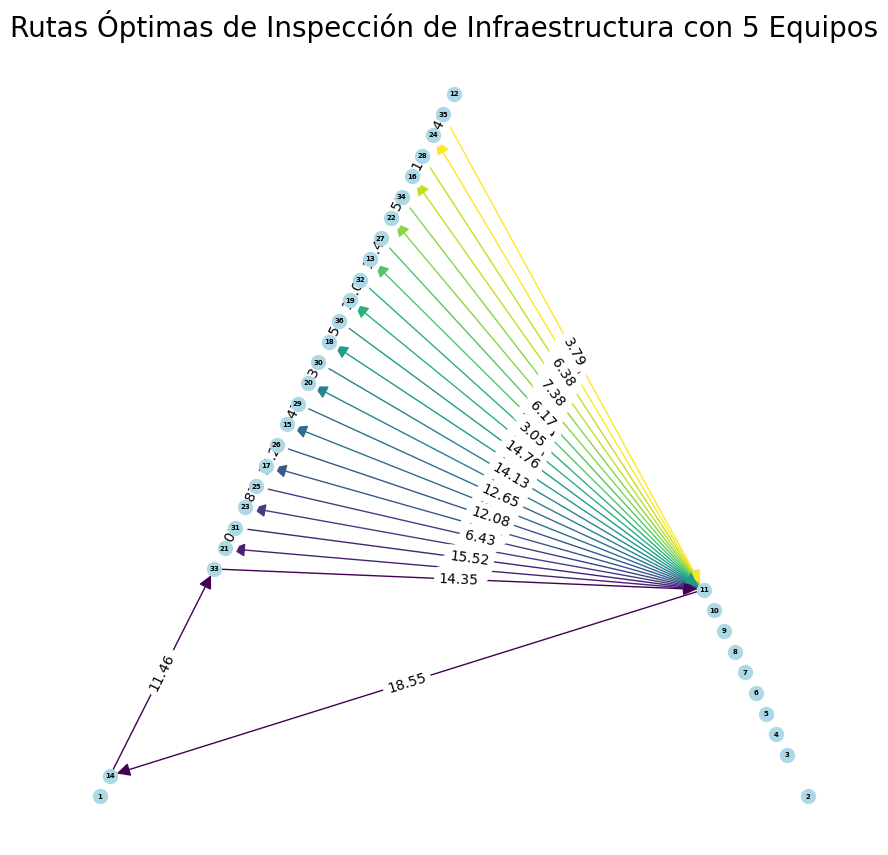

{1: array([-0.91100703, -0.46448087]),
 2: array([ 1.        , -0.46448087]),
 3: array([ 0.94379391, -0.40827479]),
 4: array([ 0.91569087, -0.38017174]),
 5: array([ 0.88758782, -0.3520687 ]),
 6: array([ 0.85948478, -0.32396565]),
 7: array([ 0.83138173, -0.29586261]),
 8: array([ 0.80327869, -0.26775956]),
 9: array([ 0.77517564, -0.23965652]),
 10: array([ 0.7470726 , -0.21155347]),
 11: array([ 0.71896956, -0.18345043]),
 12: array([0.04449649, 0.49102264]),
 13: array([-0.18032787,  0.26619828]),
 14: array([-0.88290398, -0.43637783]),
 15: array([-0.40515222,  0.04137393]),
 16: array([-0.06791569,  0.37861046]),
 17: array([-0.46135831, -0.01483216]),
 18: array([-0.29274005,  0.1537861 ]),
 19: array([-0.23653396,  0.20999219]),
 20: array([-0.34894614,  0.09758002]),
 21: array([-0.57377049, -0.12724434]),
 22: array([-0.12412178,  0.32240437]),
 23: array([-0.5175644 , -0.07103825]),
 24: array([-0.0117096 ,  0.43481655]),
 25: array([-0.48946136, -0.04293521]),
 26: array(

In [ ]:

# Extraer las rutas seleccionadas
selected_routes = []
for k in vehiculos:
    routes_for_k = [(i, j) for i in ubicaciones for j in ubicaciones if i != j and Model.x[i, j, k].value == 1]
    print(f"Rutas seleccionadas para el viajero {k}: {routes_for_k}")
    selected_routes.append(routes_for_k)

# Crear el grafo usando NetworkX
G = nx.DiGraph()

# Añadir ubicaciones
for i in ubicaciones:
    G.add_node(i)

for k in range(num_vehiculos):
    for route in selected_routes[k]:
        i, j = route
        G.add_edge(i, j, weight=f"{costos_distancia[i-1,j-1]:.2f}",color=k)

# Dibujar el grafo
edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]
pos = nx.planar_layout(G)  # Usar un layout circular para una visualización clara
labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold', arrowsize=20, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Rutas Óptimas de Inspección de Infraestructura con 5 Equipos", size=20)
plt.show()
pos